In [1]:
import os

import pandas as pd 
import numpy as np
import seaborn as sns

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter

In [2]:
dir_artifacts = '/labs/shahlab/projects/lguo/temp_ds_shift_robustness/clmbr/experiments/clmbr/adapter_artifacts/'

#### Get sweep results

In [3]:
df_sweep = pd.DataFrame()
for encoder in ['gru']:
    for task in ['hospital_mortality','LOS_7','readmission_30','icu_admission']:
        fpath = os.path.join(
            dir_artifacts,
            task,
            f'eval/{encoder}_lr_2009_2010_2011_2012_sweep'
        )
        models = [x for x in os.listdir(fpath)]
        for model in models:
            df = pd.read_csv(os.path.join(fpath,model))
            df_sweep = pd.concat((
                df_sweep, 
                df.assign(
                    model_num=model.split('.')[0] if 'best_model' not in model else model.split('.')[0].split('_')[-1],
                    best_model=1 if 'best_model' in model else 0,
                    task=task,
                    encoder=encoder
                )
            ))

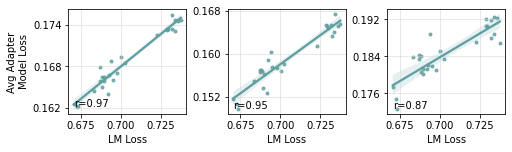

In [5]:
metrics = {
    'auc':'AUC',
    'auprc_c':'AUPRC',
    'loss_bce':'Loss',
    'ace_abs_logistic_logit':'ACE',
}

year_groups = ['2009_2010_2011_2012','2013_2014_2015_2016','2017_2018_2019_2020_2021']
tasks = ['hospital_mortality','LOS_7','icu_admission','readmission_30']
encoders = ['gru']
metric='loss_bce'

df=df_sweep.query('test_group==@year_groups and metric==@metric and CI_quantile_95=="mid"').reset_index(drop=True)
df=df.groupby(['test_group','encoder','model_num','task'])[['comparator','delta']].mean().reset_index()
df['model_num']=df['model_num'].astype(int)

df_clmbr = pd.read_csv("/labs/shahlab/projects/lguo/temp_ds_shift_robustness/clmbr/experiments/clmbr/clmbr_artifacts/clmbr_losses_1.csv")
df_clmbr['model_num'] = df_clmbr['model_num'].astype(int)

df=df_clmbr[['loss','model_num','encoder']].merge(
    df, 
    on=['model_num','encoder']
)

df['perplexity']=np.exp(df['loss'])

clmbr_y = 'loss'

for encoder in encoders:
    fig,axes = plt.subplots(1,3,figsize=(7,2),constrained_layout=True)

    for c,group in enumerate(year_groups):
        
        data = df.query("encoder==@encoder and test_group==@group").groupby(['model_num']).mean().reset_index()

        sns.regplot(
            data=data,
            x=clmbr_y,
            y='comparator',
            ax=axes[c],
            color='cadetblue',
            marker='.'
        )
        
        if c==0: 
            axes[c].set_ylabel(f"Avg Adapter\nModel Loss")
        else:
            axes[c].set_ylabel(f"")
            
        axes[c].set_xlabel(f"LM Loss")
        axes[c].grid(which='major',color='lightgrey',linewidth=0.5)
        axes[c].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        axes[c].yaxis.set_major_locator(MaxNLocator(nbins=3,prune='both'))
        axes[c].text(
            data[clmbr_y].min(),
            data['comparator'].min(),
            f"r={round(pearsonr(data[clmbr_y],data['comparator'])[0],2)}"
        )
            
    plt.savefig('figs/corr_gru_avg.png',dpi=300)
    plt.show()

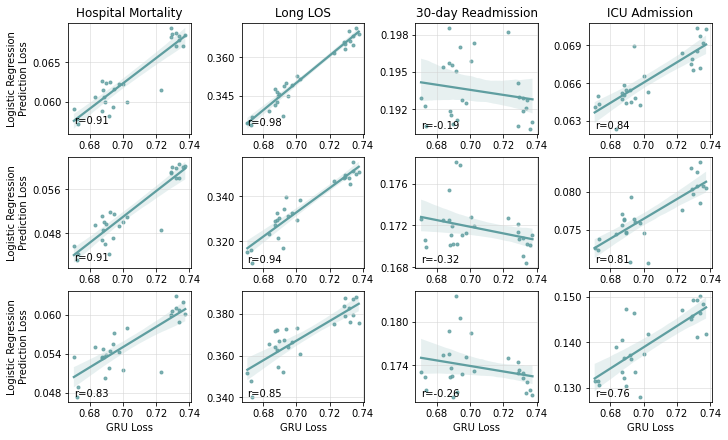

In [7]:
fig,axes = plt.subplots(len(year_groups),len(tasks),figsize=(10,6),constrained_layout=True)

tasks = {
    'hospital_mortality':'Hospital Mortality',
    'LOS_7':'Long LOS',
     'readmission_30':'30-day Readmission',
    'icu_admission':'ICU Admission',
}

for c,task in enumerate(tasks):
    for r,group in enumerate(year_groups):
        
        data = df.query("encoder==@encoder and test_group==@group and task==@task").groupby(['model_num']).mean().reset_index()

        sns.regplot(
            data=data,
            x='loss',
            y='comparator',
            ax=axes[r][c],
            color='cadetblue',
            marker='.'
        )
        
        if c==0:
            axes[r][c].set_ylabel(f"Logistic Regression\nPrediction Loss")
        else:
            axes[r][c].set_ylabel(f"")
        
        if r==0:
            axes[r][c].set_title(f"{tasks[task]}")
        
        if r==len(year_groups)-1:
            axes[r][c].set_xlabel(f"GRU Loss")
        else:
            axes[r][c].set_xlabel("")
            
        axes[r][c].grid(which='major',color='lightgrey',linewidth=0.5)
        axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=3,prune='both'))
        axes[r][c].text(
            data.loss.min(),
            data.comparator.min(),
            f"r={round(pearsonr(data['loss'],data['comparator'])[0],2)}"
        )
        
    plt.savefig(f'figs/corr_gru_all.png',dpi=300)
plt.show()